In [ ]:
!apt install swig
!pip install orthnet

In [2]:

import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

from orthnet import Legendre, Chebyshev

%matplotlib inline

GPU_MODE = True

In [3]:
if GPU_MODE:
  cuda0 = torch.device('cuda:0')
  print(torch.cuda.device_count(), torch.cuda.get_device_name(0))
  torch.cuda.init()

1 NVIDIA GeForce GTX 1070


In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [5]:
class LegendreActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 , i):
            if (i + j) % 2 == 1:
              self.D[i, j] = 2 * (j + 1) - 1
    
    def forward(self, X):              
      data = Legendre(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T


class LegendreBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Legendre = LegendreActivation(self.degree)

    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Legendre(X)
      return data

class ChebyshevActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 ,i):
            if (i+j) % 2 == 1:
              self.D[i, j] = 2 * i
              if j == 0:
                self.D[i, j] = self.D[i, j]/2.0
    def forward(self, X):              
      data = Chebyshev(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T

class ChebyshevBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Chebyshev = ChebyshevActivation(self.degree)


    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Chebyshev(X)
      
      return data

In [6]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

In [7]:
domain = [0, 6]
n_discretization = 3000 * domain[1] - domain[0]

In [8]:
n_input = 1
n_output = 1
eps = 1e-10

In [9]:
if GPU_MODE:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double, device=cuda0).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()
else:
  x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double).reshape(-1,1)
  x = Variable(x, requires_grad=True).double()

In [11]:
mlp = nn.Sequential(  
  LegendreBlock(n_input, 16),
  ChebyshevBlock(16, 5),
  nn.Linear(5, n_output)
).double()


pytorch_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
pytorch_total_params

25

In [12]:
if GPU_MODE:
  mlp.to('cuda:0')

In [13]:
def get_loss(x, ret_res=False):
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Generall Falkner-Skan Eq.: 
    f''' + α ff'' + β(1 - (f')^2) = 0 ,
    f(0) = f'(0) = 0, f'(∞) = 1
  
  Pohlhausen Flow = (α, β) = (0, 1)  
  """
  alpha = 0
  beta = 1

  residual = (y_xxx) + (alpha * y_xx * y) + (beta * (1 - y_x**2))


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [14]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [17]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 10000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().cpu().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().cpu().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00000.0000068534
Step: 002 loss = 00000.0442246897
Step: 004 loss = 00000.2750316651
Step: 006 loss = 00000.2612009791
Step: 008 loss = 00000.0758928055
Step: 010 loss = 00000.0786317183
Step: 012 loss = 00000.1198532458
Step: 014 loss = 00000.0418960139
Step: 016 loss = 00000.0433891284
Step: 018 loss = 00000.0526656204
Step: 020 loss = 00000.0338108630
Step: 022 loss = 00000.0283543610
Step: 024 loss = 00000.0192619806
Step: 026 loss = 00000.0136371994
Step: 028 loss = 00000.0226689838
Step: 030 loss = 00000.0100218073
Step: 032 loss = 00000.0048131323
Step: 034 loss = 00000.0137565984
Step: 036 loss = 00000.0071342709
Step: 038 loss = 00000.0008130230
Step: 040 loss = 00000.0068810621
Step: 042 loss = 00000.0051846865
Step: 044 loss = 00000.0009811861
Step: 046 loss = 00000.0030364989
Step: 048 loss = 00000.0026380256
Step: 050 loss = 00000.0012668378
Step: 052 loss = 00000.0010408723
Step: 054 loss = 00000.0013458786
Step: 056 loss = 00000.0011919974
Step: 058 loss

In [19]:
# calculate f''(0)
# # make zero Tensor from x Tensor
zerox = x.clone()
zerox[0][0] = 0
f_xx_0 = d2y_dx2(mlp(zerox), zerox)[0]
print("f''(0) = {}".format(f_xx_0[0]))


#  Exact = 1.154701

f''(0) = 1.1547091770274447


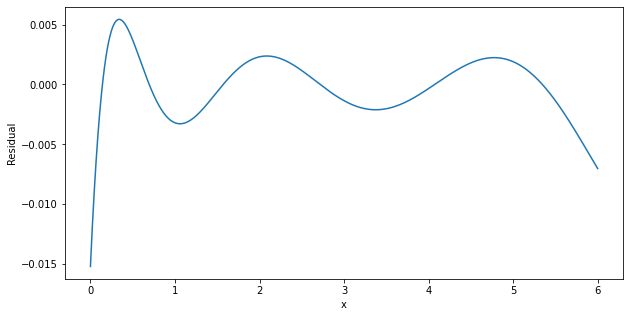

In [20]:
mlp.to('cpu')
plt.figure(figsize=(10, 5))
domain = x.cpu().detach().numpy().flatten()

res= get_loss(x.cpu(), ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

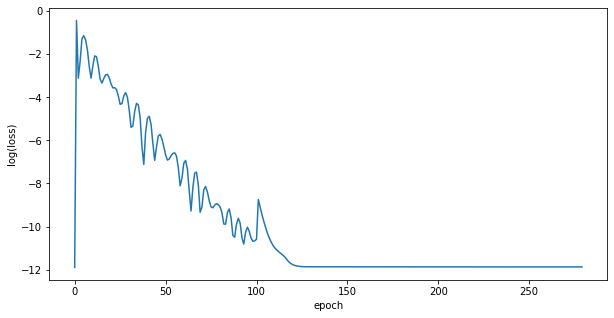

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')